# SIMULATION CHECKING AND VISUALIZING

In [2]:
from autoscalingsim import simulator
import pandas as pd

starting_time = pd.Timestamp("2020-09-17T10:00:00")
simulation_step = pd.Timedelta(50, unit = 'ms')
time_to_simulate = pd.Timedelta(150, unit = 's')
config_dir = "experiments/topologies/topo_d"#"experiments/short-experiment/reactive"
#"experiments/short-experiment/reactive-mapping"#"experiments/testazuremanual2"#"experiments/test"#
results_dir = None

simulator = simulator.Simulator(simulation_step, starting_time, time_to_simulate, 666)

simulator.add_simulation(config_dir, results_dir)

simulator.start_simulation()

3001it [18:34,  2.69it/s]                                                                                              


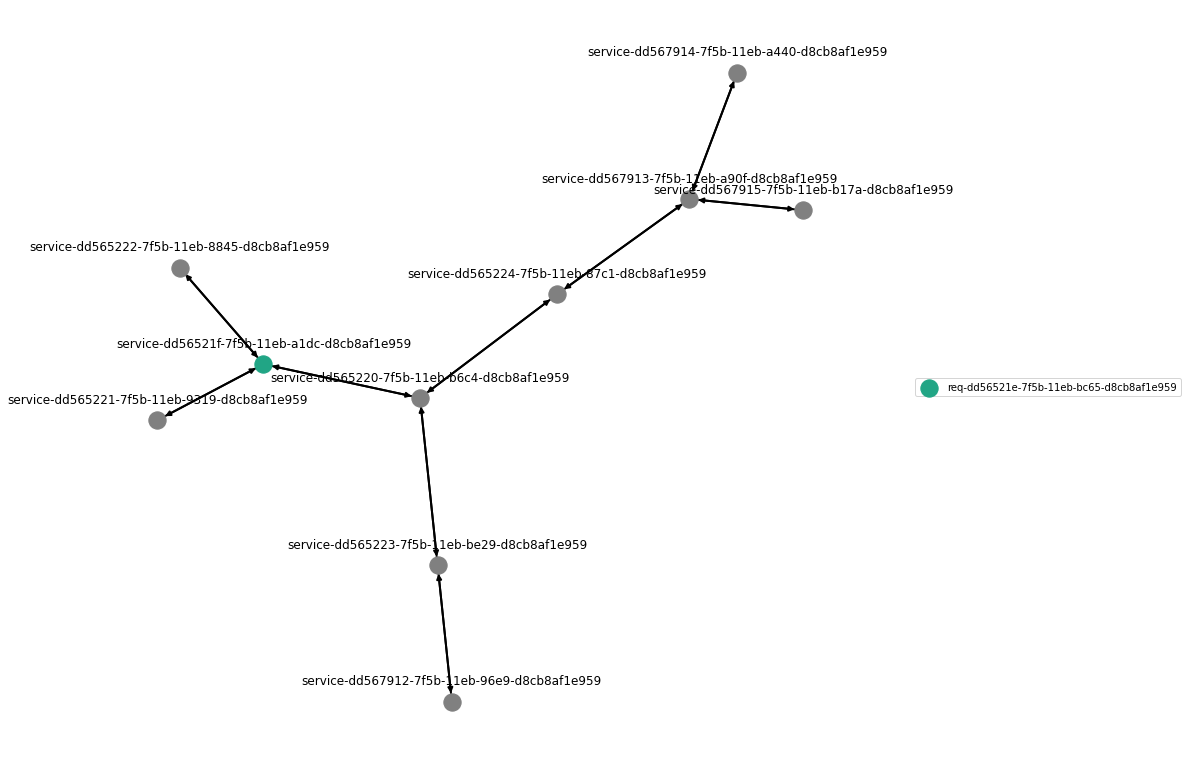

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
from stethoscope.analytical_engine import AnalysisFramework

af = AnalysisFramework(simulation_step, 'D:/AutoscalingSim/results/test/topologies/topo_d')
af.build_figures_for_single_simulation(simulator.simulations['topo_d'], '')#af.build_figures_for_single_simulation(simulator.simulations['test'], '')#

# VISUALIZING TRAINING PROGRESS FOR DEEP MODELS

In [13]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

def produce_training_plot(dir_with_log : str):

    log = pd.read_csv(os.path.join(dir_with_log, 'training_log.csv'), sep = ';', header = None,names = ['simtime', 'service', 'metrics_group', 'region', 'divergence'])
    services = log.service.unique()
    
    fig = plt.figure(figsize = (16, 10))
    ax = fig.add_subplot(1, 1, 1)
    for service in services:
        service_training_log = log[log.service == service].reset_index()[['divergence']]

        ax.plot(service_training_log.rolling(100).mean(), label = service)

    ax.axhline(0.25, 0, 1.0, color = 'k', linestyle = 'solid', lw = 2)
    ax.legend(loc = 'upper right')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('Training iterations count', fontsize = 18)
    plt.ylabel('Scaled error', fontsize = 18)
    plt.savefig(os.path.join(dir_with_log, 'learning.png'), dpi = 600, bbox_inches = 'tight')

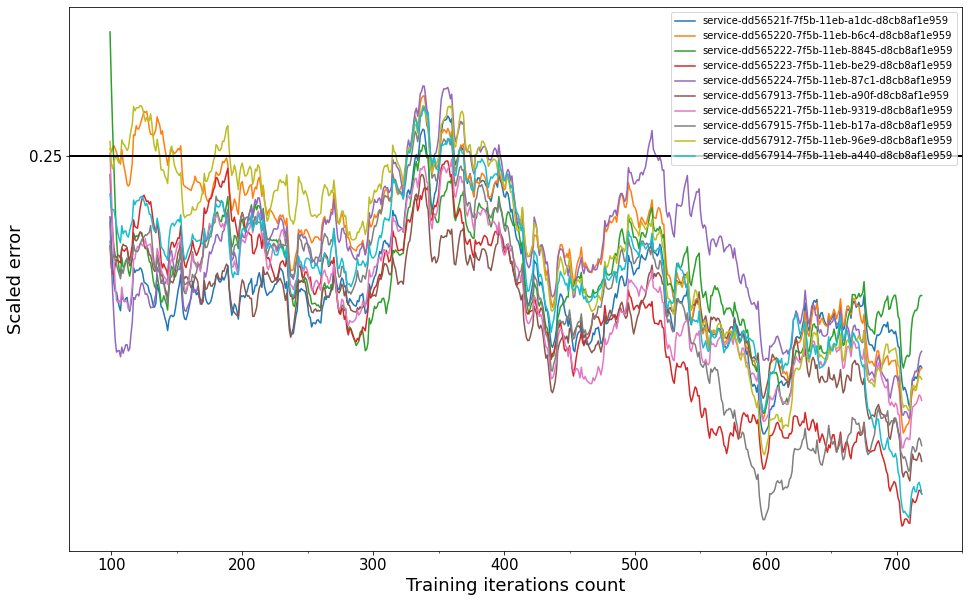

In [15]:
dir_with_log = 'D:/AutoscalingSim/autoscaling-simulator/results_thesis/mapping-models/topologies/reps_1_40/topo_d'
produce_training_plot(dir_with_log)

# LOAD PATTERNS EXPERIMENTATION

In [1]:
services_by_app = {
    'topo_a': [
        'service-7edf312e-7e71-11eb-aac0-d8cb8af1e959',
        'service-7edf312f-7e71-11eb-a3f8-d8cb8af1e959',
        'service-7edf3133-7e71-11eb-9bac-d8cb8af1e959',
        'service-7edf3135-7e71-11eb-baf5-d8cb8af1e959',
        'service-7edf5818-7e71-11eb-b9e3-d8cb8af1e959',
        'service-7edf3131-7e71-11eb-9cb2-d8cb8af1e959',
        'service-7edf3134-7e71-11eb-9d1a-d8cb8af1e959',
        'service-7edf3130-7e71-11eb-88ac-d8cb8af1e959',
        'service-7edf5819-7e71-11eb-800c-d8cb8af1e959',
        'service-7edf3132-7e71-11eb-a32d-d8cb8af1e959'
    ],
    'topo_b': [
        'service-1d1bdea9-7f3b-11eb-abf0-d8cb8af1e959',
        'service-1d1bdeaa-7f3b-11eb-8cbf-d8cb8af1e959',
        'service-1d1bdead-7f3b-11eb-8c6e-d8cb8af1e959',
        'service-1d1bdeae-7f3b-11eb-bf1c-d8cb8af1e959',
        'service-1d1bdeaf-7f3b-11eb-bbf6-d8cb8af1e959',
        'service-1d1bdeb0-7f3b-11eb-9a4a-d8cb8af1e959',
        'service-1d1c0586-7f3b-11eb-bb38-d8cb8af1e959',
        'service-1d1bdeab-7f3b-11eb-8bce-d8cb8af1e959',
        'service-1d1bdeb1-7f3b-11eb-a6d0-d8cb8af1e959',
        'service-1d1bdeac-7f3b-11eb-95d1-d8cb8af1e959'
    ],
    'topo_c': [
        'service-a0856b68-7f3d-11eb-a7e8-d8cb8af1e959',
        'service-a0856b69-7f3d-11eb-bcd9-d8cb8af1e959',
        'service-a0856b6d-7f3d-11eb-af79-d8cb8af1e959',
        'service-a0856b6c-7f3d-11eb-8578-d8cb8af1e959',
        'service-a0856b6b-7f3d-11eb-b68a-d8cb8af1e959',
        'service-a0856b6e-7f3d-11eb-9268-d8cb8af1e959',
        'service-a0856b6a-7f3d-11eb-a26d-d8cb8af1e959',
        'service-a0856b6f-7f3d-11eb-b24f-d8cb8af1e959',
        'service-a0856b70-7f3d-11eb-a12c-d8cb8af1e959',
        'service-a0859374-7f3d-11eb-a379-d8cb8af1e959'
    ],
    'topo_d': [
        'service-dd56521f-7f5b-11eb-a1dc-d8cb8af1e959',
        'service-dd565220-7f5b-11eb-b6c4-d8cb8af1e959',
        'service-dd565222-7f5b-11eb-8845-d8cb8af1e959',
        'service-dd565223-7f5b-11eb-be29-d8cb8af1e959',
        'service-dd565224-7f5b-11eb-87c1-d8cb8af1e959',
        'service-dd567913-7f5b-11eb-a90f-d8cb8af1e959',
        'service-dd565221-7f5b-11eb-9319-d8cb8af1e959',
        'service-dd567915-7f5b-11eb-b17a-d8cb8af1e959',
        'service-dd567912-7f5b-11eb-96e9-d8cb8af1e959',
        'service-dd567914-7f5b-11eb-a440-d8cb8af1e959'
    ]
}

In [ ]:
# Simple load pattern prep
import pandas as pd
import numpy as np

idx = pd.date_range(start = '2020-09-17T08:00:00', end = '2020-09-17T08:59:59', freq = '1s')
sub_idx_onwards = idx[idx >= pd.Timestamp('2020-09-17T08:01:00')]
sub_idx_before = idx[idx < pd.Timestamp('2020-09-17T08:01:00')]
load = [ 3 + np.random.choice(3) if ts.minute % 2 == 0 else 1 + np.random.choice(2) for ts in sub_idx_onwards ]
load = [ 0 ] * len(sub_idx_before) + load
load_ts = pd.DataFrame(data = {'value': load}, index = idx)

load_ts.resample(pd.Timedelta(1, unit = 'm')).sum().plot()

<AxesSubplot:>

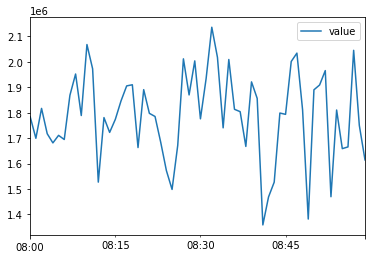

In [2]:
# Check different ARIMA-based load patterns
import statsmodels.api as sm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

idx = pd.date_range(start = '2020-09-17T08:00:00', end = '2020-09-17T08:59:59', freq = '1s')
empty_dataset = np.zeros(len(idx))
mod = sm.tsa.SARIMAX(empty_dataset, order=(2, 0, 1), seasonal_order = (0, 0, 1, 120), trend='c', initialization='diffuse')
load = 30000 * (mod.simulate([0, 0.8, 0.01, 0.5, 0.01, 0.01], len(idx)) + 1.0)
load_ts = pd.DataFrame(data = {'value': load}, index = idx)

load_ts.resample(pd.Timedelta(1, unit = 'm')).sum().plot()

In [3]:
# Offline forecasting models fitting
import pickle
import os
import statsmodels.api as sm

def fit_forecasting_model(load_ts : pd.DataFrame, base_path : str, filename_pattern : str, metric : str, model_name : str, app_name : str, regions : list, services : str):

    load_ts_r = load_ts.resample(pd.Timedelta(1, unit = 'm')).sum()
    mdl = None
    if model_name == 'arima':
        mdl = sm.tsa.SARIMAX(load_ts_r.value, order = (2, 0, 1), seasonal_order = (0, 0, 1, 2), trend='c', initialization='diffuse').fit()
    elif model_name == 'holtwinters':
        init_conf = { 'trend' : None,  'damped_trend' : None,  'seasonal' : "add", "seasonal_periods": 2 }
        mdl = sm.tsa.ExponentialSmoothing(load_ts_r.value, **init_conf).fit(smoothing_level = 0.7, smoothing_trend = None, smoothing_seasonal = 1.0, damping_trend = None, optimized = False)
    
    print(f'{model_name} prediction:\n {mdl.predict(start = load_ts_r.index.max() + pd.Timedelta(1, unit = "m"), end = load_ts_r.index.max() + pd.Timedelta(20, unit = "m"))}')
    model_path = base_path.format(app_name, model_name)
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_path = os.path.join(model_path, filename_pattern)
    
    for service_name in services:
        for region in regions:
            model_fpath = model_path.format(service_name, region, metric)
            pickle.dump(mdl, open( model_fpath, 'wb') )

In [5]:
base_path = 'D:\\AutoscalingSim\\autoscaling-sim\\autoscaling-simulator\\trained_models\\forecasting\\arima-based\\{}\\{}'
filename_pattern = '{}-{}-{}.mdl'

regions = ['eu']
metric = 'load'
model_name = 'holtwinters'

fit_forecasting_model(load_ts, base_path, filename_pattern, metric, model_name, 'topo_a', regions, services_by_app['topo_a'])
fit_forecasting_model(load_ts, base_path, filename_pattern, metric, model_name, 'topo_b', regions, services_by_app['topo_b'])
fit_forecasting_model(load_ts, base_path, filename_pattern, metric, model_name, 'topo_c', regions, services_by_app['topo_c'])
fit_forecasting_model(load_ts, base_path, filename_pattern, metric, model_name, 'topo_d', regions, services_by_app['topo_d'])

holtwinters prediction:
 2020-09-17 09:00:00    1.093969e+06
2020-09-17 09:01:00    1.880027e+06
2020-09-17 09:02:00    1.093969e+06
2020-09-17 09:03:00    1.880027e+06
2020-09-17 09:04:00    1.093969e+06
2020-09-17 09:05:00    1.880027e+06
2020-09-17 09:06:00    1.093969e+06
2020-09-17 09:07:00    1.880027e+06
2020-09-17 09:08:00    1.093969e+06
2020-09-17 09:09:00    1.880027e+06
2020-09-17 09:10:00    1.093969e+06
2020-09-17 09:11:00    1.880027e+06
2020-09-17 09:12:00    1.093969e+06
2020-09-17 09:13:00    1.880027e+06
2020-09-17 09:14:00    1.093969e+06
2020-09-17 09:15:00    1.880027e+06
2020-09-17 09:16:00    1.093969e+06
2020-09-17 09:17:00    1.880027e+06
2020-09-17 09:18:00    1.093969e+06
2020-09-17 09:19:00    1.880027e+06
Freq: T, dtype: float64
holtwinters prediction:
 2020-09-17 09:00:00    1.093969e+06
2020-09-17 09:01:00    1.880027e+06
2020-09-17 09:02:00    1.093969e+06
2020-09-17 09:03:00    1.880027e+06
2020-09-17 09:04:00    1.093969e+06
2020-09-17 09:05:00    1.8

C:\Users\Remit\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [4]:
# Other patterns generation with Camel
from camel import camel

print(camel.Camel.generate_load_pattern_based_on_recipe("camel_conf/oscillating-5min.json"))

[{"requests_count_level": 0, "percentage_of_interval": 0.2},
{"requests_count_level": 2000, "percentage_of_interval": 0.2},
{"requests_count_level": 1000, "percentage_of_interval": 0.2},
{"requests_count_level": 2000, "percentage_of_interval": 0.2},
{"requests_count_level": 1000, "percentage_of_interval": 0.2}]


# EXPERIMENTS GENERATION BASED ON TRACES (AZURE)

In [20]:
from experimentgenerator.experiment_generator import ExperimentGenerator
a = ExperimentGenerator('experiments/topologies/topo_d')
a.generate_experiment('experiment_recipes/topologies/topo_d.json')

Processing vmtable.csv: iteration 1
Processing vmtable.csv: iteration 2
Processing vmtable.csv: iteration 3
Processing vmtable.csv: iteration 4
Processing vmtable.csv: iteration 5
Processing vmtable.csv: iteration 6
Processing vmtable.csv: iteration 7
Processing vmtable.csv: iteration 8
Processing vmtable.csv: iteration 9
Processing vmtable.csv: iteration 10
Processing vmtable.csv: iteration 11
Processing vmtable.csv: iteration 12
Processing vmtable.csv: iteration 13
Processing vmtable.csv: iteration 14
Processing vmtable.csv: iteration 15
Processing vmtable.csv: iteration 16
Processing vmtable.csv: iteration 17
Processing vmtable.csv: iteration 18
Processing vmtable.csv: iteration 19
Processing vmtable.csv: iteration 20
Processing vmtable.csv: iteration 21
Processing vmtable.csv: iteration 22
Processing vmtable.csv: iteration 23
Processing vmtable.csv: iteration 24
Processing vmtable.csv: iteration 25
Processing vmtable.csv: iteration 26
Processing vmtable.csv: iteration 27
Processing

# EVALUATING ALTERNATIVE CONFIGS, E.G. REACTIVE VS PREDICTIVE

In [1]:
from cruncher.cruncher import Cruncher

c = Cruncher('cruncher_conf/experiment_1/')
c.run_experiment()

12001it [00:39, 303.26it/s]                                                                                            
12001it [00:39, 303.96it/s]                                                                                            
12001it [00:39, 301.70it/s]                                                                                            
12001it [00:39, 304.54it/s]                                                                                            


In [2]:
c.visualize('D:/@TUM/PhD/FINAL/experimentresults/data')

# PERFORMANCE EVALUATION OF THE SIMULATOR

In [ ]:
from autoscalingsim import simulator
import pandas as pd
import collections
import time
import pickle

simulation_steps_ms = [10,20,30,40,50,60,70,80,90,100]
starting_time = pd.Timestamp("2020-09-17T10:00:00")
time_to_simulate = pd.Timedelta(10, unit = 'm')
repeats = 10

results = collections.defaultdict(list)
for sim_step_raw in simulation_steps_ms:
    print(f'current simulation step is {sim_step_raw} ms')
    for _ in range(repeats):
        start = time.time()
        simulation_step = pd.Timedelta(sim_step_raw, unit = 'ms')
        config_dir = "experiments/testazuremanual2"
        results_dir = None

        sim = simulator.Simulator(simulation_step, starting_time, time_to_simulate)

        sim.add_simulation(config_dir, results_dir)

        sim.start_simulation()
        
        results[sim_step_raw].append(time.time() - start)
        
pickle.dump( results, open( "performance_test_results_raw.pickle", "wb" ) )

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

res = pickle.load( open( "performance_test_results_raw.pickle", "rb" ) )

results_means = [np.mean(times_per_simstep) / (10 * 60) for times_per_simstep in res.values()]
results_stds = [np.std(times_per_simstep) / (10 * 60) for times_per_simstep in res.values()]
steps = np.arange(10, 101, 10)

p1 = plt.bar(steps, results_means, 7, yerr=results_stds)

plt.ylabel('Wall clock time per 1 simulated second, s')
plt.xlabel('Simulation step, ms')
plt.xticks(steps)
plt.yticks(np.arange(0.0, 2.0, 0.1))
plt.hlines(0.5, xmin = 5, xmax = 105, colors = 'r', linestyles = 'dashed')
#plt.show()

plt.savefig("./performance_results.png", dpi = 600, bbox_inches='tight')

# Diminishing returns:
(10 * 60_000) / steps

In [ ]:
# To profile:
# python -m cProfile -o D:\AutoscalingSim\results\profiling_res.txt autoscalingsim-cl.py --step 10 --start "2020-09-17T10:00:00" --confdir "experiments/test" --simtime 1m
import pstats
from pstats import SortKey
p = pstats.Stats('D://AutoscalingSim//results//profiling_res.txt')
p.strip_dirs().sort_stats(SortKey.CALLS).print_stats()